In [16]:
%pylab inline

import matplotlib
import seaborn
seaborn.set(style="dark")
rcParams['figure.figsize'] = (16, 5)

from IPython.display import Audio

import numpy as np
import librosa
import pysptk
import pysas
from scipy.io import wavfile

Populating the interactive namespace from numpy and matplotlib


/home/gergo/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['gamma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [17]:
sr, x = wavfile.read('data_raw/wav/arctic_a0001.wav')
assert sr == 16000
print(x.shape)

(64000,)


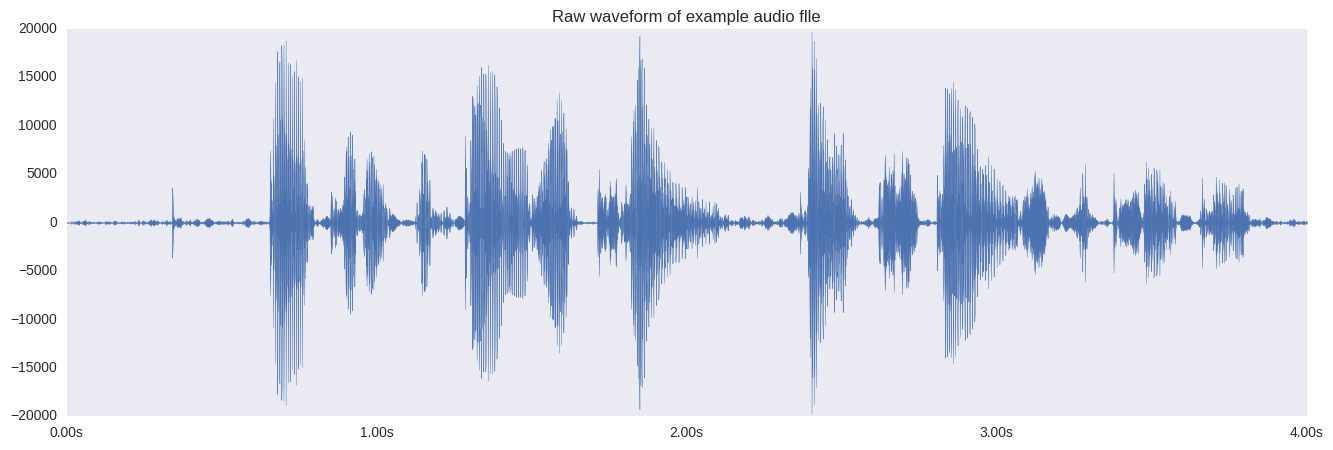

In [18]:
librosa.display.waveplot(x, sr=sr)
title("Raw waveform of example audio flle")
Audio(x, rate=sr)

## Source parameter extraction
### Framing and windowing

In [19]:
frame_length = 1024
hop_length = 80

# Note that almost all of pysptk functions assume input array is C-contiguous and np.float4 element type
frames = librosa.util.frame(x, frame_length=frame_length, hop_length=hop_length).astype(np.float64).T

# Windowing
frames *= pysptk.blackman(frame_length)

assert frames.shape[1] == frame_length 

### F0 estimation

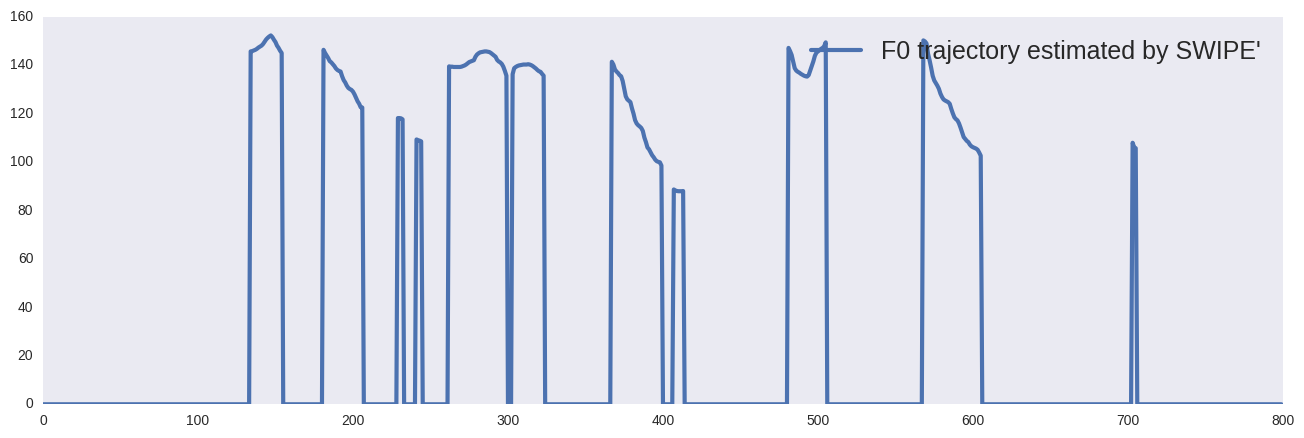

In [20]:
# F0 estimation
f0 = pysptk.swipe(x.astype(np.float64), fs=sr, hopsize=hop_length, min=60, max=240, otype="f0")
plot(f0, linewidth=3, label="F0 trajectory estimated by SWIPE'")
xlim(0, len(f0))
legend(prop={'size': 18})

## Source excitation generation

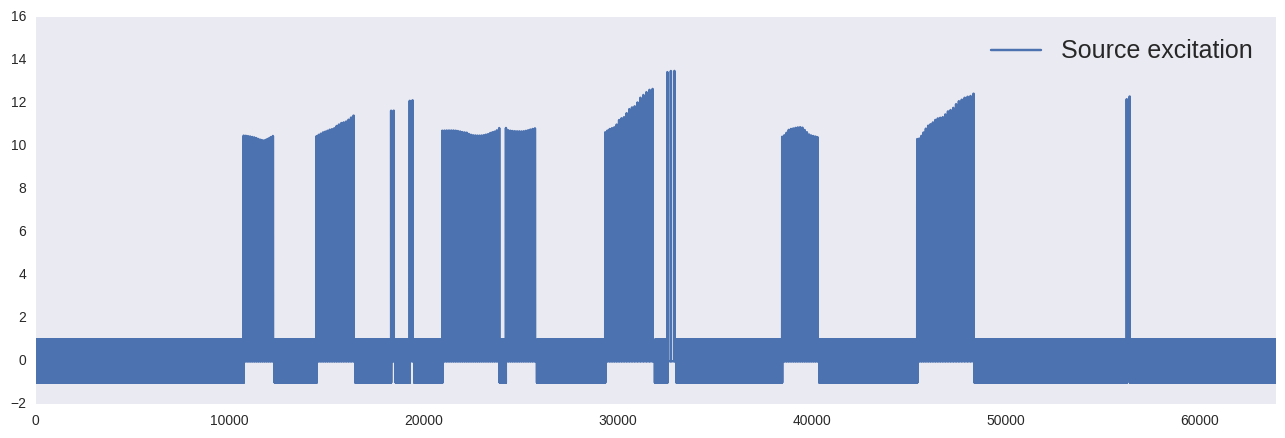

In [21]:
# Note that pysptk.excite assuems input as pitch, not *f0*.
pitch = pysptk.swipe(x.astype(np.float64), fs=sr, hopsize=hop_length, min=60, max=240, otype="pitch")
source_excitation = pysptk.excite(pitch, hop_length)
                            
plot(source_excitation, label="Source excitation")
xlim(0, len(source_excitation))
ylim(-2, 16)
legend(prop={'size': 18})

## Synthesis from mel-cepstrum

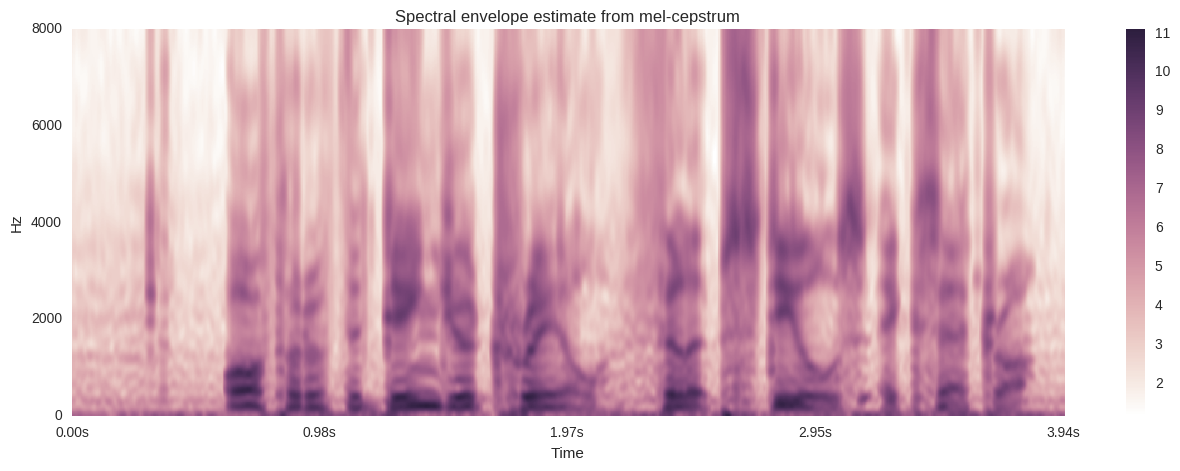

In [22]:
# Order of mel-cepstrum
order = 25
alpha = 0.41

# apply function along with `time` axis (=1)
mc = np.apply_along_axis(pysptk.mcep, 1, frames, order, alpha) # numpy >= v0.19.0 also supports keyword arguments like alpha=0.41 as well

logH = np.apply_along_axis(pysptk.mgc2sp, 1, mc, alpha, 0.0, frame_length).real
librosa.display.specshow(logH.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="linear")
colorbar()
title("Spectral envelope estimate from mel-cepstrum")

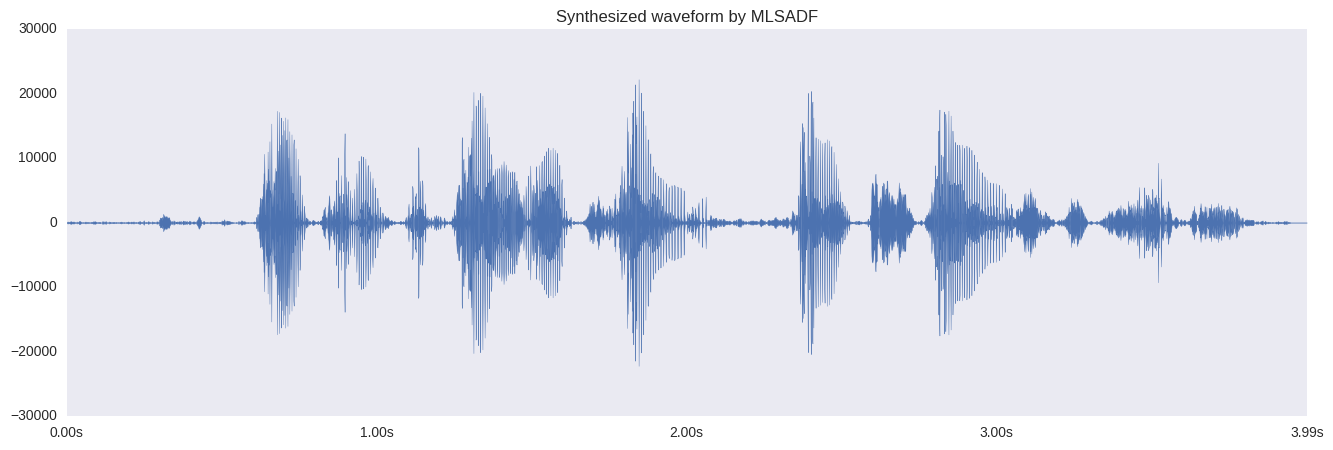

In [23]:
from pysptk.synthesis import MLSADF, Synthesizer

# Convert mel-cesptrum to MLSADF coefficients
b = np.apply_along_axis(pysptk.mc2b, 1, mc, alpha);

synthesizer = Synthesizer(MLSADF(order=order, alpha=alpha), hop_length)

mc_synthesized = synthesizer.synthesis(source_excitation, b)

librosa.display.waveplot(mc_synthesized, sr=sr)
title("Synthesized waveform by MLSADF")
Audio(mc_synthesized, rate=sr)

## Synthesis from cepstrum

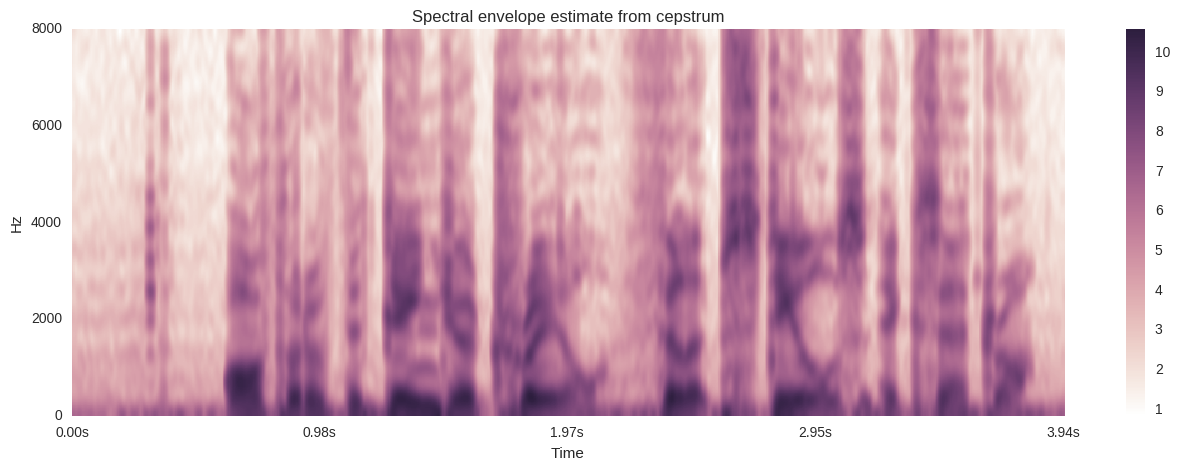

In [24]:
# Order of mel-cepstrum
order = 25

# apply function along with `time` axis (=1)
c = np.apply_along_axis(pysptk.mcep, 1, frames, order, 0.0)

logH = np.apply_along_axis(pysptk.mgc2sp, 1, c, 0.0, 0.0, frame_length).real
librosa.display.specshow(logH.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="linear")
colorbar()
title("Spectral envelope estimate from cepstrum")

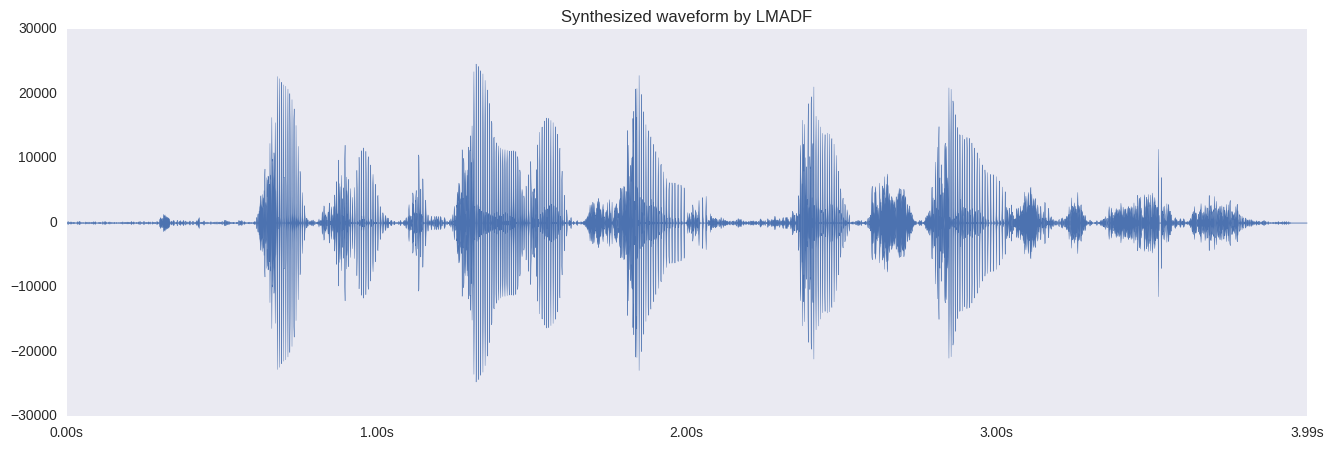

In [25]:
from pysptk.synthesis import LMADF

synthesizer = Synthesizer(LMADF(order=order), hop_length)

c_synthesized = synthesizer.synthesis(source_excitation, c)

librosa.display.waveplot(c_synthesized, sr=sr)
title("Synthesized waveform by LMADF")
Audio(c_synthesized, rate=sr)

## Synthesis from mel-generalized cepstrum

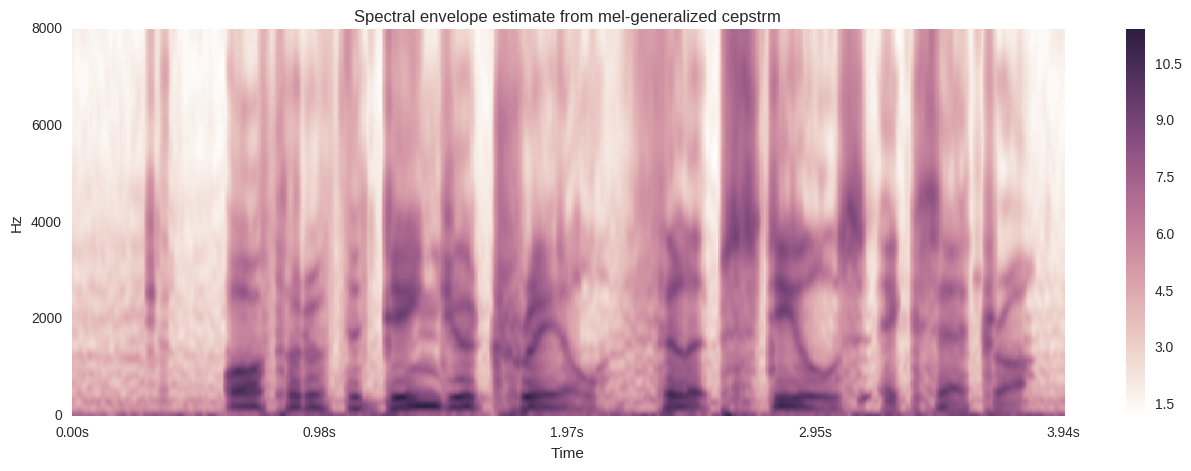

In [26]:
# Order of mel-cepstrum
order = 25
alpha = 0.41
stage = 5
gamma = -1.0 / stage

# apply function along with `time` axis (=1)
mgc = np.apply_along_axis(pysptk.mgcep, 1, frames, order, alpha, gamma)

logH = np.apply_along_axis(pysptk.mgc2sp, 1, mgc, alpha, gamma, frame_length).real
librosa.display.specshow(logH.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="linear")
colorbar()
title("Spectral envelope estimate from mel-generalized cepstrm")

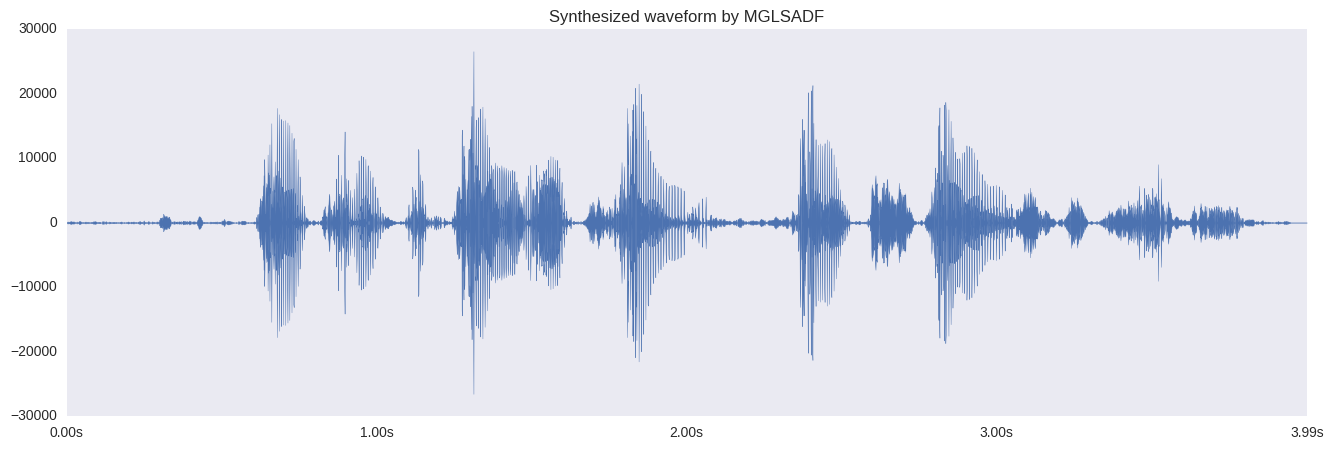

In [27]:
from pysptk.synthesis import MGLSADF

# Convert mel-generalized cesptrum to MGLSADF coefficients
b = np.apply_along_axis(pysptk.mgc2b, 1, mgc, alpha, gamma);

synthesizer = Synthesizer(MGLSADF(order=order, alpha=alpha, stage=stage), hop_length)

mgc_synthesized = synthesizer.synthesis(source_excitation, b)

librosa.display.waveplot(mgc_synthesized, sr=sr)
title("Synthesized waveform by MGLSADF")
Audio(mgc_synthesized, rate=sr)

## Synthesis from LPC

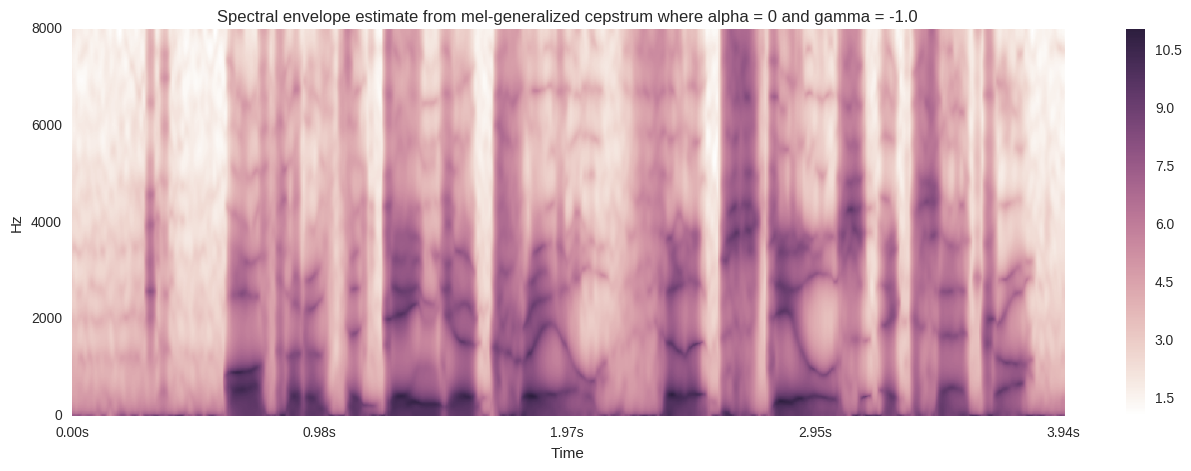

In [28]:
# Order of mel-cepstrum
order = 25

# apply function along with `time` axis (=1)
mgc = np.apply_along_axis(pysptk.mgcep, 1, frames, order, 0.0, -1.0)

logH = np.apply_along_axis(pysptk.mgc2sp, 1, mgc, 0.0, -1.0, frame_length).real
librosa.display.specshow(logH.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="linear")
colorbar()
title("Spectral envelope estimate from mel-generalized cepstrum where alpha = 0 and gamma = -1.0")

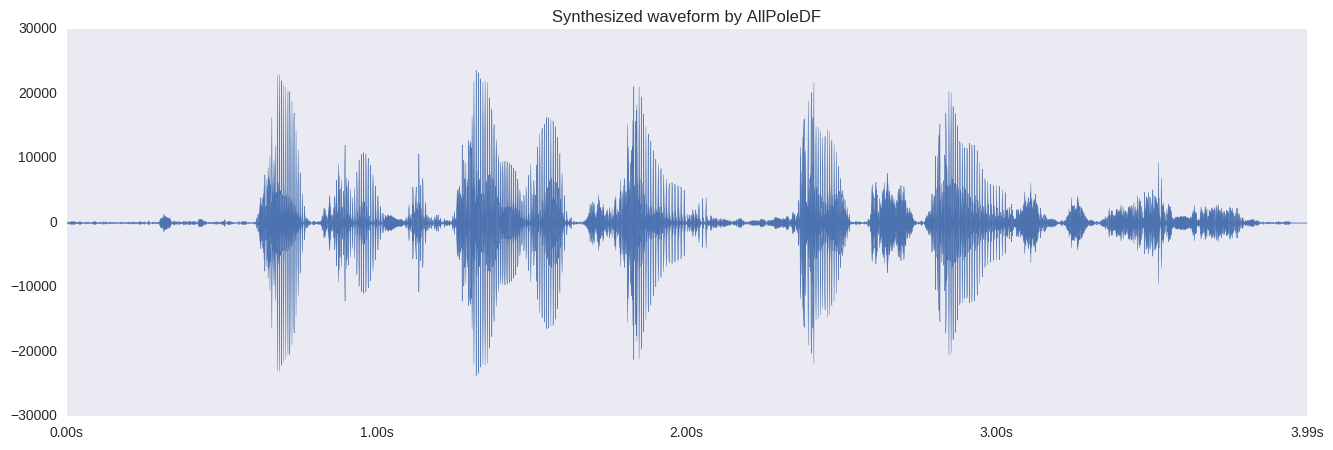

In [29]:
from pysptk.synthesis import AllPoleDF

lpc = np.apply_along_axis(pysptk.lpc, 1, frames, order)

# make sure lpc has loggain
lpc[:, 0] = np.log(lpc[:, 0])

synthesizer = Synthesizer(AllPoleDF(order=order), hop_length)

lpc_synthesized = synthesizer.synthesis(source_excitation, lpc)

librosa.display.waveplot(lpc_synthesized, sr=sr)
title("Synthesized waveform by AllPoleDF")
Audio(lpc_synthesized, rate=sr)

In [30]:
print(np.shape(mc),
      np.shape(c),
      np.shape(mgc),
      np.shape(lpc))
print(np.shape(mc_synthesized),
      np.shape(c_synthesized),
      np.shape(mgc_synthesized),
      np.shape(lpc_synthesized),
      np.shape(x[80:]))

(788, 26) (788, 26) (788, 26) (788, 26)
(63920,) (63920,) (63920,) (63920,) (63920,)


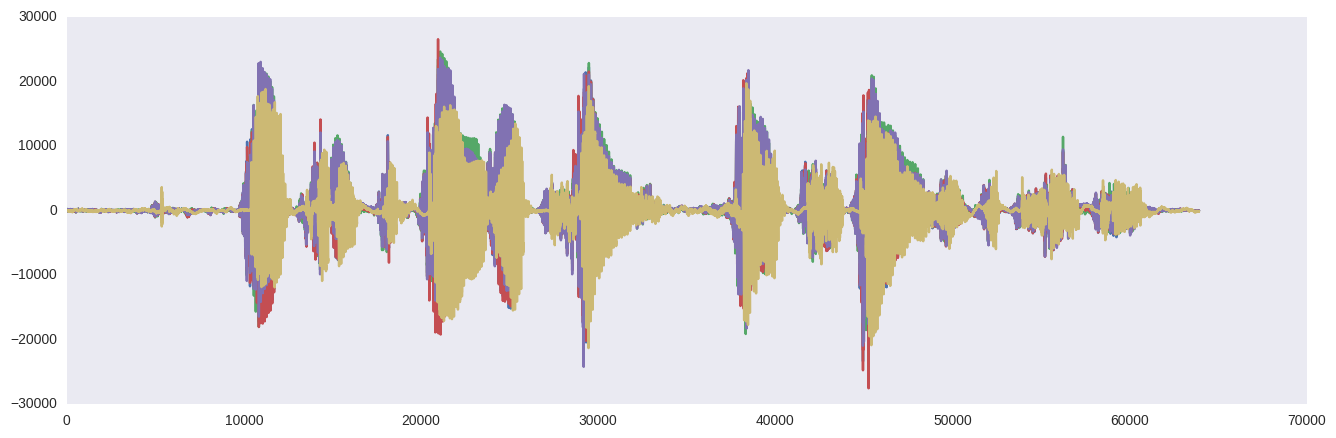

In [31]:
plot(mc_synthesized)
plot(c_synthesized)
plot(mgc_synthesized)
plot(lpc_synthesized)
plot(x[80:])

In [32]:
Audio(x[80:], rate=sr)

In [33]:
def maxabs(a, axis=None):
    """Return slice of a, keeping only those values that are furthest away
    from 0 along axis"""
    maxa = np.max(a,axis=axis)
    mina = np.min(a,axis=axis)
    p = np.abs(maxa) > np.abs(mina) # bool, or indices where +ve values win
    n = np.abs(mina) > np.abs(maxa) # bool, or indices where -ve values win
    if axis == None:
        if p: return maxa
        else: return mina
    shape = list(np.shape(a))
    shape.pop(axis)
    out = np.zeros(shape, dtype=a.dtype)
    out[p] = maxa[p]
    out[n] = mina[n]
    return out

In [34]:
def minabs(a, axis=None):
    """Return slice of a, keeping only those values that are furthest away
    from 0 along axis"""
    maxa = np.max(a,axis=axis)
    mina = np.min(a,axis=axis)
    p = np.abs(maxa) < np.abs(mina) # bool, or indices where +ve values win
    n = np.abs(mina) < np.abs(maxa) # bool, or indices where -ve values win
    if axis == None:
        if p: return maxa
        else: return mina
    shape = list(np.shape(a))
    shape.pop(axis)
    out = np.zeros(shape, dtype=a.dtype)
    out[p] = maxa[p]
    out[n] = mina[n]
    return out

In [35]:
s_max = minabs(np.array([mc_synthesized,c_synthesized,mgc_synthesized,lpc_synthesized]), axis=0)
s_min = maxabs(np.array([mc_synthesized,c_synthesized,mgc_synthesized,lpc_synthesized]), axis=0)
s = np.average(np.array([s_max,s_min]),axis=0)

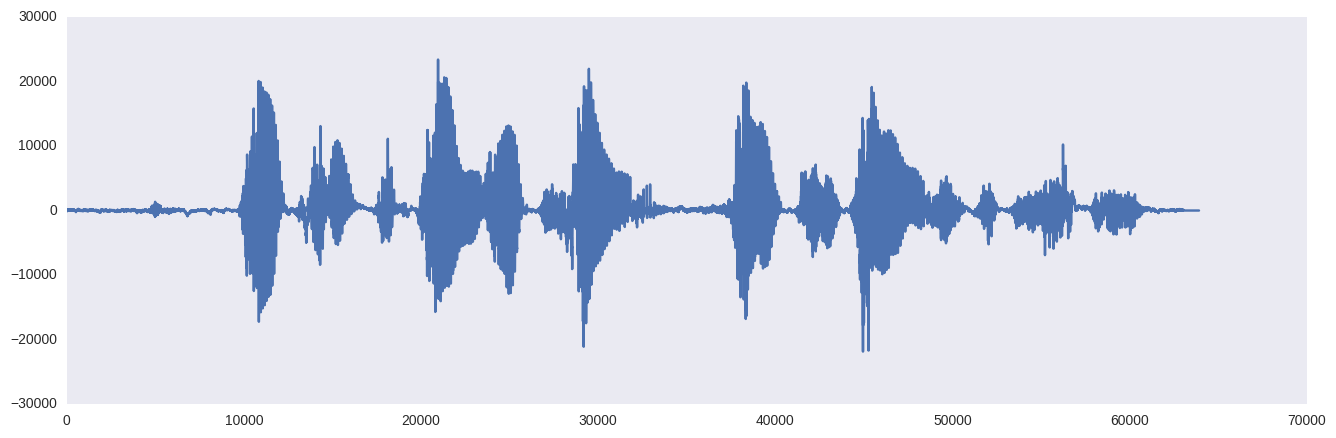

In [36]:
plot(s)

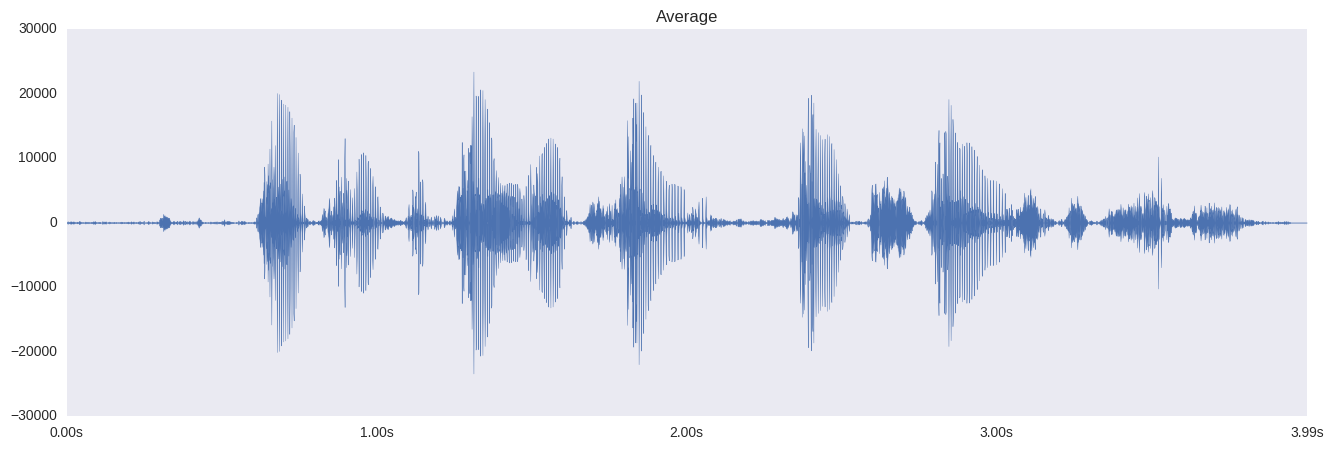

In [37]:
librosa.display.waveplot(s, sr=sr)
title("Average")

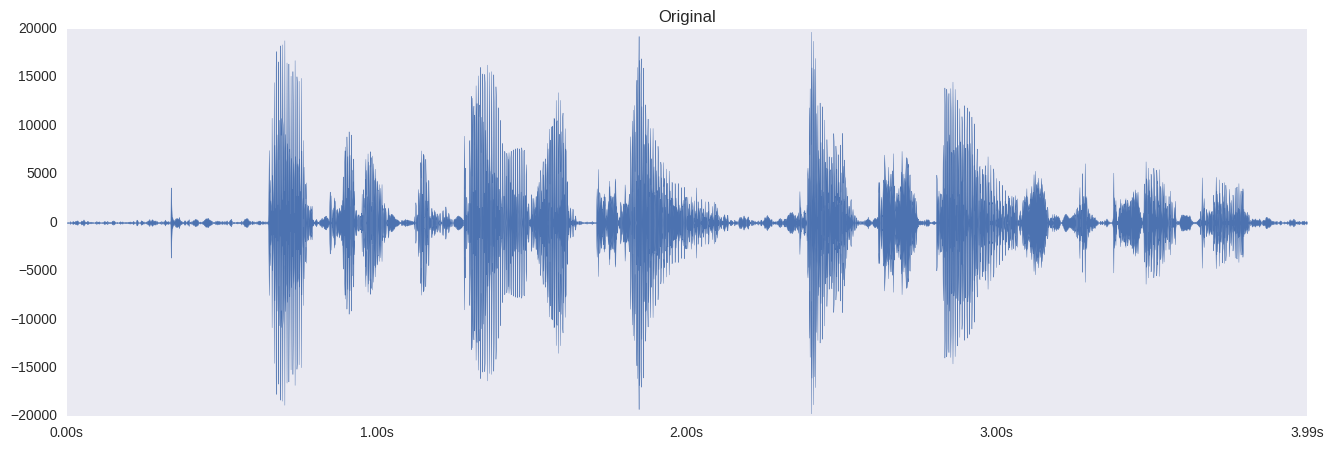

In [38]:
librosa.display.waveplot(x[80:], sr=sr)
title("Original")

In [39]:
sgen = Audio(s, rate=sr)

In [40]:
Audio(x, rate=sr)

In [41]:
wavfile.write('output_examples/mc.wav',sr,mc_synthesized)

In [42]:
wavfile.write('output_examples/c.wav',sr,c_synthesized)

In [43]:
wavfile.write('output_examples/x.wav',sr,x)

In [44]:
wavfile.write('output_examples/s.wav',sr,s)

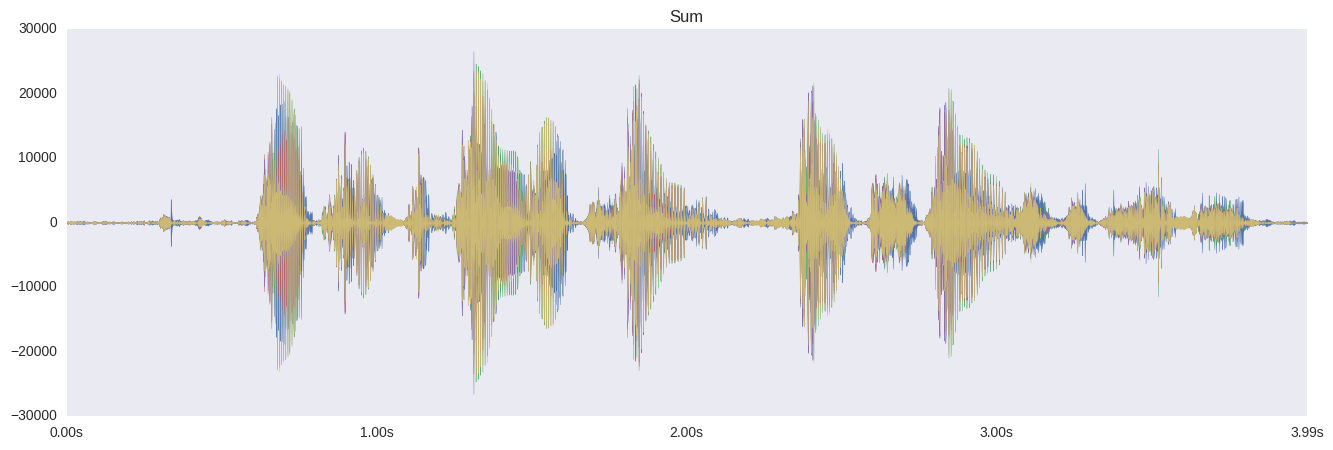

In [46]:
librosa.display.waveplot(x[80:], sr=sr)
librosa.display.waveplot(c_synthesized, sr=sr)
librosa.display.waveplot(mc_synthesized, sr=sr)
librosa.display.waveplot(mgc_synthesized, sr=sr)
librosa.display.waveplot(lpc_synthesized, sr=sr)

title("Sum")